<a href="https://colab.research.google.com/github/mistryvivek/A-Level-NEA/blob/main/PADL_Week_1_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PADL Practical 1: Machine learning refresher and an introduction to PyTorch

We will begin with a revision of the concepts of machine learning, loss functions and optimisation. We will use a trivial example to get started. We'll also see something new: the concept of differentiable programming using PyTorch. This makes a lot of what we want to do in machine learning extremely easy to implement.

*Machine learning* is a computational approach in which a system learns to map inputs to outputs by "learning" from training data. In reality, "learning" means *optimisation* (usually minimisation) of a *loss function*. In the case of *supervised learning* our training data provides pairs of inputs and the corresponding desired output. Our "machine" is a function of a particular form whose behaviour is determined by some parameters. Our job is to find the parameters that give a function that maps input to output such that the loss over the training set is minimised.

## A trivial example: the constant machine

Imagine a machine learning task where you need to predict a scalar value - i.e. the machine has a single output. Maybe we want to predict the height of people taking PADL. *But*, this machine has *zero inputs*. In that case, the machine must always predict the same single value. It's a very trivial machine that just always returns a constant since it has no input from which to change its behaviour. What would be the best value for the machine to always predict?

Simply the mean average! Or perhaps some other kind of average (depending on how you define "centrality" for your application).

You were taught the formula for computing the mean back in secondary school:

$$\bar{x} = \frac{1}{n} \sum_{i=1}^n x_i$$

You should all find it easy to compute this in python/numpy. Let's start by generating a dataset of 9 random numbers:

In [40]:
import numpy as np

n = 9
x = np.random.rand(n)

and then compute the mean average:

In [2]:
mean = 1.0/float(n) * np.sum(x)
print(mean)

0.5651004843964157


Of course, numpy has mean average as a built in function:

In [3]:
mean = np.mean(x)
print(mean)

0.5651004843964158


## Deriving the mean

So far so simple...

But do you know *why* that's the formula for the mean?

###Mean as optimisation problem

Actually, this formula is the solution to an optimisation problem. It is the value that minimises the squared differences to all data points:

$$\bar{x}=\arg\min_{\bar{x}} \sum_{i=1}^n (\bar{x}-x_i)^2$$

In other words, if we defined sum of squared differences as our loss function and solved the resulting optimisation problem, we would get the mean as the answer.

So, how is the formula we know for the mean derived from this optimisation problem? The answer is that this optimisation problem has a *closed form solution*. This means that we can write down an equation that solves it exactly, i.e. provides the *global optimum*. To do so, we only need A-level standard maths.

###Thought you'd never have to do differentiation again?

How do we minimise a function? We need to find the *stationary points* which we get by differentiating the function, setting to zero and solving. It's a bit of a painful process for the function above, but let's do it. Start by expanding the summation and square, then multiply out the brackets and collect like terms:

$$\begin{aligned}\sum_{i=1}^n (\bar{x}-x_i)^2 &= (\bar{x}-x_1)(\bar{x}-x_1) + \dots + (\bar{x}-x_n)(\bar{x}-x_n) \\
&= \bar{x}^2 - 2x_1\bar{x} + x_1^2 + \dots \bar{x}^2 - 2x_n\bar{x} + x_n^2 \\
&= n\bar{x}^2 - 2\bar{x}\sum_{i=1}^nx_i + \sum_{i=1}^nx_i^2\end{aligned}$$

In terms of $\bar{x}$, can you see what sort of function we have now? It's just a quadratic! i.e.

$$f(\bar{x}) = a\bar{x}^2 + b\bar{x} + c$$

where $a$, $b$ and $c$ happen to be:

$$a=n,\quad b=-2\sum_{i=1}^nx_i,\quad c=\sum_{i=1}^nx_i^2.$$

Now, hopefully you all remember how to differentiate $a\bar{x}^2 + b\bar{x} + c$? It's simply:

$$\frac{\partial f}{\partial \bar{x}} = 2a\bar{x} + b$$

Now set to zero and solve:

$$\begin{aligned}2a\bar{x} + b&=0\\
\bar{x}=\frac{-b}{2a}\end{aligned}$$

Now plug in $a$ and $b$:

$$\bar{x}=\frac{2\sum_{i=1}^nx_i}{2n}=\frac{1}{n} \sum_{i=1}^n x_i$$

It's the formula for the mean that we know and love!

**Wow - that was pretty painful right?!**

And that was for just about the most trivial machine learning problem you could possibly imagine (no inputs, one output, sum of squared errors as the loss). Consider a multilayer perceptron with many layers, nonlinear activation functions and a logistic regression layer on the end for classification. Imagine trying to differentiate that by hand! (And it wouldn't have a closed form solution anyway...)

##Differentiable programming

We'll now see a totally different way of solving optimisation problems (and it might mean you never have to do differentiation by hand again!) The idea is that we simply write code that computes the loss function, i.e. the thing we want to minimise, from some given input.

A differentiable programming language can then automatically differentiate backwards from our loss function, all the way through our series of instructions right back to the input(s). At any point through this chain of differentiation, we can ask: what is the gradient of the loss function with respect to some parameters at this point in the chain? And we can use this to optimise the loss function using gradient descent (or some other algorithm) automatically.

We're going to see a particular example of differentiable programming: PyTorch.

Let's repeat the above example but this time, instead of differentiating and solving by hand, we'll use differentiable programming in PyTorch and solve by iterative optimisation.

In [4]:
import torch

# Copy the sequence of numbers from numpy array to PyTorch tensor
xt = torch.from_numpy(x)

The above just imports the main PyTorch libraries and then copies the dataset x from a numpy array to a PyTorch **tensor**. These are very similar in that both are multidimensional arrays and can be indexed and sliced in similar ways. But PyTorch tensors can easily be transferred to a GPU (essential for processing large datasets quickly) and have many useful operations that are automatically differentiable. Tensors are the fundamental data type in PyTorch: every layer in our neural networks will take one or more tensors as input and output one or more tensors. We'll learn more about them later but that will do for now.

Let's get on with something more interesting: let's write some code to compute our loss function.

In [5]:
def sum_squared_differences(average,xt):
    loss = torch.sum((xt-average)**2.0)
    return loss

This function takes as input the current estimate of the mean value and the dataset as a tensor. All it does inside the function is compute the sum of squared errors between the estimate of the mean and all elements in the dataset. Notice how we used a PyTorch operation `torch.sum`? We could equally have used the sum method of the tensor to get the same effect:

`loss = ((xt-mean)**2.0).sum()`

There is no difference - it's just a matter of coding style and I will mix the two.

##Optimisation in PyTorch

We've written down our loss function, now it's time to iteratively optimise it. Like any iterative optimisation, we need an initialisation. Let's just use a random number for our initial guess at the mean. There's also a couple of other things we need to set up:

In [27]:
# Let's initialise our estimate of the mean randomly
average = torch.rand(1)

# Could just take one of the value for initialisation.
#average = xt[0]
#OR to avoid computational link
average = xt[0].clone()

# We need to tell PyTorch that we need the gradient of the loss with respect to the mean
average.requires_grad=True
# Set up the optimiser and tell it that the variable to optimise is the mean
optim = torch.optim.SGD([average], lr=0.01)

`optim` is now an optimiser object that will use the Stochastic Gradient Descent algorithm (the "stochastic" part only comes in when we talk about batching data - in this particular example it will just run normal gradient descent). We have to give it an iterable list containing the parameters to be optimised (in our case just `average` - and note that we had to set `requires_grad` to true because we need to know the gradient of the loss with respect to this parameter). Our optimiser has one hyperparameter: `lr` is the learning rate. I've set it to a value that should work ok. Now we're ready to optimise.

In [30]:
niter = 100
for step in range(niter):
    # Run forward pass to compute our loss function
    loss = sum_squared_differences(average,xt)
    # Reset the gradients in the optimiser object to zero
    optim.zero_grad()
    # MAGIC! (See below)
    loss.backward()
    # Update all parameters with one gradient descent step
    optim.step()
    if not step % 5:
        # Display iteration number, current loss and current estimate of the mean
        print("Step %d, loss %0.6f, mean %0.6f" % (step, loss, average))

Step 0, loss 0.938305, mean 0.592434
Step 5, loss 0.929680, mean 0.575234
Step 10, loss 0.928494, mean 0.568857
Step 15, loss 0.928331, mean 0.566493
Step 20, loss 0.928309, mean 0.565617
Step 25, loss 0.928306, mean 0.565292
Step 30, loss 0.928305, mean 0.565171
Step 35, loss 0.928305, mean 0.565127
Step 40, loss 0.928305, mean 0.565110
Step 45, loss 0.928305, mean 0.565104
Step 50, loss 0.928305, mean 0.565102
Step 55, loss 0.928305, mean 0.565101
Step 60, loss 0.928305, mean 0.565101
Step 65, loss 0.928305, mean 0.565101
Step 70, loss 0.928305, mean 0.565101
Step 75, loss 0.928305, mean 0.565100
Step 80, loss 0.928305, mean 0.565100
Step 85, loss 0.928305, mean 0.565100
Step 90, loss 0.928305, mean 0.565100
Step 95, loss 0.928305, mean 0.565100


The above code ran 100 iterations of gradient descent on our loss function, updating the estimate of the mean at each iteration. Compare the final value of the mean with what you got from the closed form numpy solution above. Are they the same?

They should be similar. They're not exact because we probably didn't run enough iterations (i.e. hadn't converged) and/or our learning rate is probably not optimal.

##Autograd

Something seriously magical happened in the above code. When we called loss.backward(), PyTorch automatically works backwards through our code, starting from `loss` and computing gradients via all tensors involved in the computation of the current loss value. At some point, this process reached `average`, where it was able to compute $\partial$ `loss`/$\partial$ `average`. This saved us all the pain from earlier of differentiating by hand. Once we had this, we were able to take a gradient descent step in the line `optim.step()`. This tells the optimiser to update everything that was passed to the optimiser as an optimisation variable. If you want to read more about autograd and how it works, see here:

https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

##Summary

So, we've traded the pain of differentiating by hand for writing code to compute only the forward function. On the other hand, in this particular case we've lost the closed form solution and replaced it with something iterative, slower and dependent on hyperparameters (learning rate and number of iterations). But have we gained anything else? Yes! **Flexibility**.

If we now decide we want a different loss than sum of squared errors, we just change our code to compute something else. And it need not have a closed form solution. Let's use sum of absolute differences instead:

In [31]:
def sum_absolute_differences(average,xt):
    loss = (xt-average).abs().mean()
    return loss

niter = 100
for step in range(niter):
    loss = sum_absolute_differences(average,xt)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not step % 5:
        print("Step %d, loss %0.6f, average %0.6f" % (step, loss, average))

Step 0, loss 0.286717, average 0.566212
Step 5, loss 0.286100, average 0.571767
Step 10, loss 0.285483, average 0.577323
Step 15, loss 0.284866, average 0.582878
Step 20, loss 0.284248, average 0.588434
Step 25, loss 0.283631, average 0.593989
Step 30, loss 0.283150, average 0.597323
Step 35, loss 0.283137, average 0.598434
Step 40, loss 0.283150, average 0.597323
Step 45, loss 0.283137, average 0.598434
Step 50, loss 0.283150, average 0.597323
Step 55, loss 0.283137, average 0.598434
Step 60, loss 0.283150, average 0.597323
Step 65, loss 0.283137, average 0.598434
Step 70, loss 0.283150, average 0.597323
Step 75, loss 0.283137, average 0.598434
Step 80, loss 0.283150, average 0.597323
Step 85, loss 0.283137, average 0.598434
Step 90, loss 0.283150, average 0.597323
Step 95, loss 0.283137, average 0.598434


Any idea what this just computed? It's a different kind of average... You might get a clue if we look at the original data in order:

In [32]:
print(xt.sort())

torch.return_types.sort(
values=tensor([0.1180, 0.1875, 0.2696, 0.3950, 0.5978, 0.6459, 0.9408, 0.9589, 0.9723],
       dtype=torch.float64),
indices=tensor([2, 0, 7, 4, 6, 5, 8, 3, 1]))


It's the middle value, i.e. the median! (Or would be if the optimisation has converged). **Interesting eh?!** The median is also the solution to an optimisation problem, this time the sum of absolute differences.

In [33]:
print(np.median(x))

0.5978199410959172


## Tidying up

There's a few loose ends to tie up. First of all, PyTorch has lots of useful loss functions already built-in. For example "sum of absolute differences" would be called "L1 loss with sum reduction" in PyTorch. We could replace the definition of sum_absolute_differences with a built-in PyTorch loss:

`sum_absolute_differences = torch.nn.L1Loss(reduction='sum')`

The only difference is that where we actually compute the loss, we explicitly need to copy the average n times since the loss function expects two tensors the same size:

`loss = sum_absolute_differences(average.repeat(9),xt)`

In [54]:
#sum_absolute_differences = torch.nn.L1Loss(reduction='sum')
mean_squared_error = torch.nn.MSELoss()
niter = 100
for step in range(niter):
    #loss = sum_absolute_differences(average.repeat(9),xt)
    loss = mean_squared_error(average.repeat(9),xt)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not step % 5:
        print("Step %d, loss %0.6f, average %0.6f" % (step, loss, average))

Step 0, loss 0.103741, average 0.589521
Step 5, loss 0.103741, average 0.589521
Step 10, loss 0.103741, average 0.589521
Step 15, loss 0.103741, average 0.589521
Step 20, loss 0.103741, average 0.589521
Step 25, loss 0.103741, average 0.589521
Step 30, loss 0.103741, average 0.589521
Step 35, loss 0.103741, average 0.589521
Step 40, loss 0.103741, average 0.589521
Step 45, loss 0.103741, average 0.589521
Step 50, loss 0.103741, average 0.589521
Step 55, loss 0.103741, average 0.589521
Step 60, loss 0.103741, average 0.589521
Step 65, loss 0.103741, average 0.589521
Step 70, loss 0.103741, average 0.589521
Step 75, loss 0.103741, average 0.589521
Step 80, loss 0.103741, average 0.589521
Step 85, loss 0.103741, average 0.589521
Step 90, loss 0.103741, average 0.589521
Step 95, loss 0.103741, average 0.589521


##Things for you to try

It's time to do some experimentation yourself.

1. What happens if you change the learning rate of the optimiser?

* Makes the learning slower as it takes smaller steps, could get stuck in local minima, may require more training steps

2. Can you think of other initialisation strategies? Using one of the input data points can be a good idea, but be careful. If you do, for example: `average = xt[0]`, you create a connection in the computational graph between `average` and `xt[0]` so the behaviour of the optimisation will not be as you expect (the value of `xt[0]` will change during the optimisation). Instead you could use: `average = xt[0].clone()`. This creates a new tensor containing the value that was in `xt[0]`.

* xt - list from numpy vector
* given solution - takes initial mean instead

3. Think up some different loss functions and try replacing sum of squared/absolute differences with these. Does changing from sum to mean reduction make a difference to the minimum obtained?

* MSE gets closer to the minimum.

4. Extra challenge: Find the minimum of the following function:
```python
   def smooth_2d_function(x, y):
     z = -(
         torch.exp(-(x - 2) ** 2 - (y - 2) ** 2) +
         2 * torch.exp(-(x + 2) ** 2 - (y + 2) ** 2)
     )
     return z
```
Note that this function depends on two variables. You will therefore need to initialise two variables that have `requires_grad=True` and pass both variables to the optimiser. Since you want to directly minimise the function itself, you don't need any additional loss function. Instead, you can simply optimise the value of this function directly using the same strategy you used to minimise a loss function in the previous exercises. What values did you find for the minimum? Do you get different results with different initialisations?:

* See answer below.
* (1.28, 1.00) -> (1.00, 1.00)
* (0.53, 0.5) -> (0.50, 0.50)
* Getting stuck in local minima, see graph below


In [65]:
def smooth_2d_function(x, y):
  z = -(
      torch.exp(-(x - 2) ** 2 - (y - 2) ** 2) +
      2 * torch.exp(-(x + 2) ** 2 - (y + 2) ** 2)
  )
  return z

In [75]:
s_2_fn_x = torch.from_numpy(np.array([0.25]))
s_2_fn_y = torch.from_numpy(np.array([0.75]))

# We need to tell PyTorch that we need the gradient of the loss with respect to the mean
# If require_grad values must fall between 0 and 1.
s_2_fn_x.requires_grad=True
s_2_fn_y.require_grad=True

"""OR:

# Initialize two variables with requires_grad=True
x = torch.tensor(0.0, requires_grad=True)
y = torch.tensor(0.0, requires_grad=True)
"""

# Set up the optimiser and tell it that the variable to optimise is the mean
optim = torch.optim.SGD([s_2_fn_x, s_2_fn_y], lr=0.01)

In [76]:
niter = 100
for step in range(niter):
    loss = smooth_2d_function(s_2_fn_x, s_2_fn_y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not step % 5:
        print("Step %d, loss %0.6f, x %0.6f, y %0.6f" % (step, loss, s_2_fn_x, s_2_fn_y))

Step 0, loss -0.009810, x 0.250343, y 0.750000
Step 5, loss -0.009869, x 0.252062, y 0.750000
Step 10, loss -0.009929, x 0.253790, y 0.750000
Step 15, loss -0.009989, x 0.255527, y 0.750000
Step 20, loss -0.010050, x 0.257273, y 0.750000
Step 25, loss -0.010111, x 0.259027, y 0.750000
Step 30, loss -0.010174, x 0.260791, y 0.750000
Step 35, loss -0.010236, x 0.262564, y 0.750000
Step 40, loss -0.010300, x 0.264346, y 0.750000
Step 45, loss -0.010364, x 0.266137, y 0.750000
Step 50, loss -0.010429, x 0.267937, y 0.750000
Step 55, loss -0.010494, x 0.269747, y 0.750000
Step 60, loss -0.010560, x 0.271567, y 0.750000
Step 65, loss -0.010627, x 0.273396, y 0.750000
Step 70, loss -0.010694, x 0.275234, y 0.750000
Step 75, loss -0.010763, x 0.277083, y 0.750000
Step 80, loss -0.010832, x 0.278941, y 0.750000
Step 85, loss -0.010901, x 0.280809, y 0.750000
Step 90, loss -0.010972, x 0.282687, y 0.750000
Step 95, loss -0.011043, x 0.284576, y 0.750000


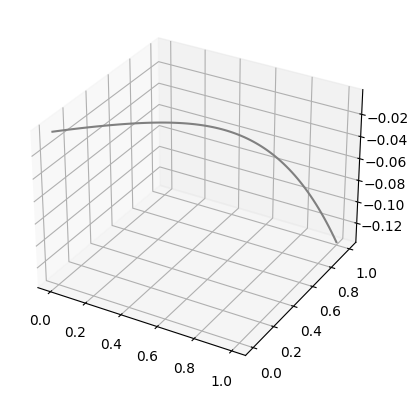

In [82]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
ax = plt.axes(projection='3d')

xline = torch.from_numpy(np.linspace(0, 1, 100))
yline = torch.from_numpy(np.linspace(0, 1, 100))
zline = smooth_2d_function(xline, yline)

ax.plot3D(xline, yline, zline, 'gray')